# How to use this notebook

This executable notebook has been build using [Binder](https://mybinder.org/) from [GitHub repository](https://github.com/tatyana-perlova/Click-Through-Rate-Analysis). You can run each individual cell with Alt+Enter or select Cell>Run All to run all cells.

In [1]:
%matplotlib inline

# Libraries

In [2]:
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process
import datetime

Plotting parameters

In [3]:
plt.style.use('fivethirtyeight')
palette = sns.palettes.color_palette()

# Load data

In [4]:
data_agg = pd.read_csv('../data/data_agg.csv', 
                       index_col=0)

In [5]:
data_agg.head()

,hour,N_clicks,N_impressions,CTR,datetime,date
0,14102100,20792,119006,0.174714,2014-10-21 00:00:00,2014-10-21
1,14102101,23873,137442,0.173695,2014-10-21 01:00:00,2014-10-21
2,14102102,31265,207471,0.150696,2014-10-21 02:00:00,2014-10-21
3,14102103,32830,193355,0.169791,2014-10-21 03:00:00,2014-10-21
4,14102104,40026,264711,0.151206,2014-10-21 04:00:00,2014-10-21


In [6]:
data_agg.datetime = pd.to_datetime(data_agg.datetime)

# Plot CTR vs time

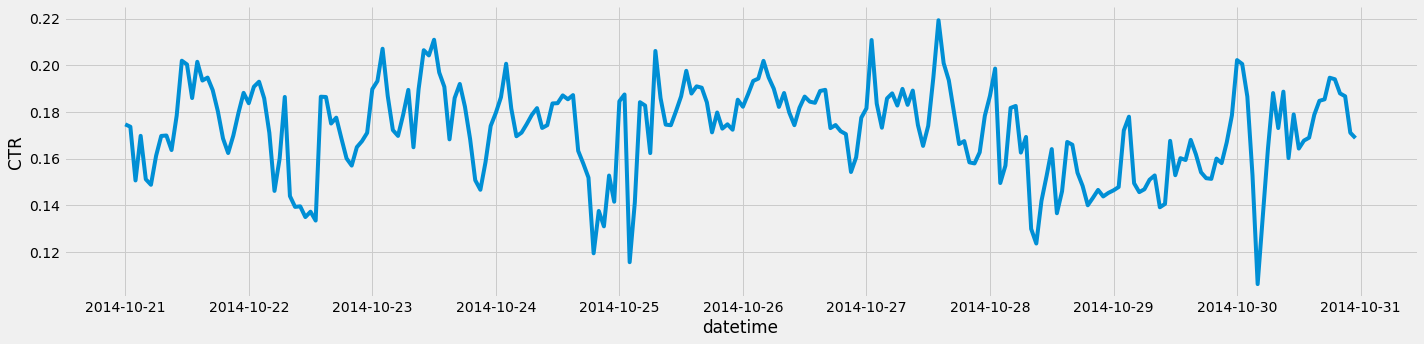

In [7]:
_ = sns.relplot(x="datetime", 
            y="CTR", 
            kind="line", 
            data=data_agg, aspect = 4)


# Find outliers

## Moving average approach

First approach to finding outliers is to calculate mean and standard deviation of CTR in a moving window and declare outliers all points that are further from the mean than certain number of standard deviations.

Here I use non-overlapping square moving windows that are one-day long. Shorter windows do not contain enough datapoints for reliable determination of distribution mean and standard deviation. Using larger windows may lead to bimodal distributions as processes that determine number of clicks may be day-specific, e.g. it's reasonable to expect that the number of clicks on a weekend will be different from the one on a weekday. For that same reason I'm using non-overlapping windows. 

**Let's examine day by day distribution of CTR**

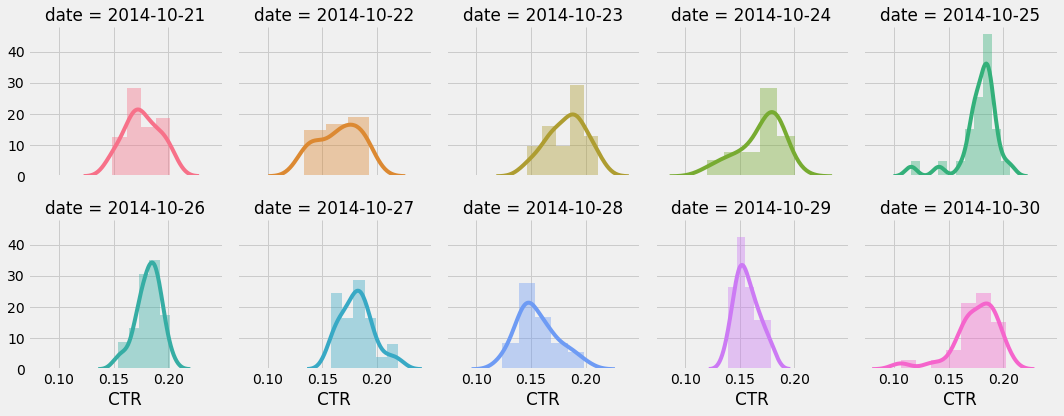

In [8]:
grid = sns.FacetGrid(data_agg, 
                     col="date", 
                     hue="date",
                     col_wrap=5, 
                     height=3)

_ = grid.map(sns.distplot, "CTR")

From looking at these distributions it's reasonable to asssume that data is normally distributed and we can use deviation from the mean to find outliers.

**Calculate mean and standard deviation**

In [9]:
data_agg['CTR_mean'] = data_agg.groupby('date').CTR.transform('mean')
data_agg['CTR_std'] = data_agg.groupby('date').CTR.transform('std')

**Find outliers**

In [10]:
n_stds = 1.5

In [11]:
data_agg['outlier'] = (data_agg.CTR < data_agg.CTR_mean - n_stds*data_agg.CTR_std) | (data_agg.CTR > data_agg.CTR_mean + n_stds*data_agg.CTR_std)

**Plot with outliers**

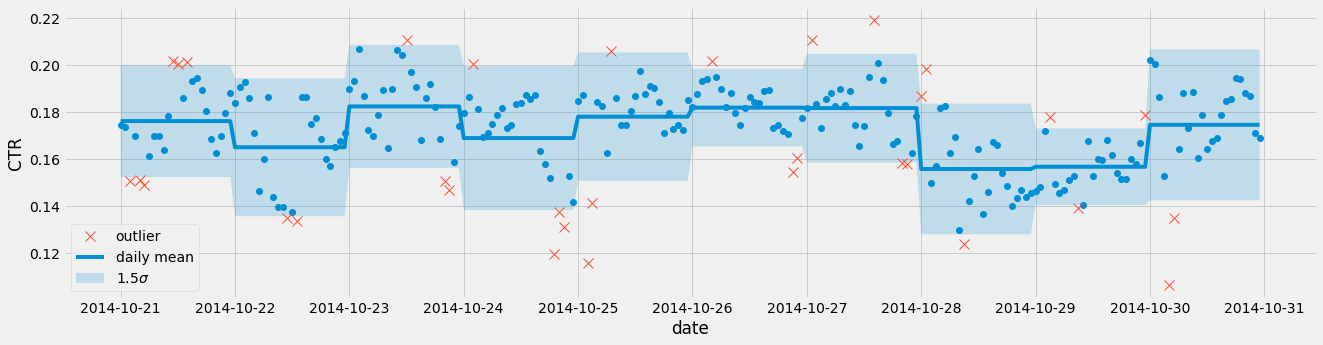

In [24]:
plt.figure(figsize=(20, 5))
plt.plot_date(data_agg[data_agg['outlier'] == False].datetime, 
              data_agg[data_agg['outlier'] == False].CTR)
plt.plot_date(data_agg[data_agg['outlier'] == True].datetime, 
              data_agg[data_agg['outlier'] == True].CTR,
             label = 'outlier',
             marker = 'x',
             markersize = 10)
plt.plot_date(data_agg.datetime,
             data_agg.CTR_mean,
            '-',
            color = palette[0],
             label = 'daily mean')
plt.fill_between(data_agg.datetime,
                data_agg.CTR_mean - data_agg.CTR_std*n_stds,
                data_agg.CTR_mean + data_agg.CTR_std*n_stds,
                alpha = 0.2,
                label = f'{n_stds}'r'$\sigma$')
plt.xlabel('date')
plt.ylabel('CTR')
_ = plt.legend()

## Gaussian process regression

The problem with the above approach is that it treats datapoints within each time window (in this case day) as independent samples from individual Gaussians used to calculated this day's mean and variance. Some days have higher variance some lower and therefore criteria used to determine the outliers will vary day by day as well. It's more reasonalbe to assume that all the observed datapoints are generated by some unknown latent function f(t) which is multivariate normally distributed (a Gaussian Process).

Below I fit a Gaussian Process regression to the CTR vs time data to estimate mean and variance of the data. The outliers are then determined the same way as before. 

**Initialize Gaussian Process**

In [13]:
#Kernel
kernel = 1**2*sklearn.gaussian_process.kernels.RBF(length_scale=5000, 
                                                  length_scale_bounds=(15000, 20000)
                                                  ) + 0*sklearn.gaussian_process.kernels.WhiteKernel(10)

#Gaussian process regressor
gpr = sklearn.gaussian_process.GaussianProcessRegressor(kernel = kernel)

**Fit Gaussian Process regression**

In [14]:
#Prepare data
x_train = data_agg['datetime'].apply(lambda x: x.timestamp())[:, None]
y_train = (data_agg.CTR - data_agg.CTR.mean())[:, None]

#Fit and predict
fit = gpr.fit(x_train, y_train)
y_pred, sigma = fit.predict(x_train, 
                            return_std=True)

/home/tatyana/anaconda3/envs/pymc_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


**Determine outliers**

In [15]:
data_agg['CTR_mean_gp'] = y_pred + data_agg.CTR.mean()
data_agg['CTR_std_gp'] = sigma
data_agg['outlier_gp'] = (data_agg.CTR < data_agg.CTR_mean_gp - n_stds*data_agg.CTR_std_gp) | (data_agg.CTR > data_agg.CTR_mean_gp + n_stds*data_agg.CTR_std_gp)

**Plot with outliers**

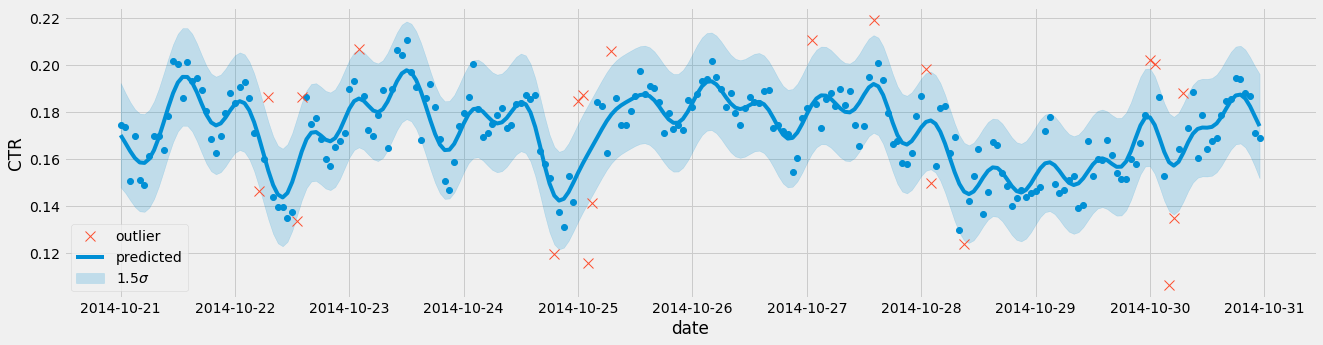

In [25]:
plt.figure(figsize=(20, 5))
plt.plot_date(data_agg[data_agg['outlier_gp'] == False].datetime, 
              data_agg[data_agg['outlier_gp'] == False].CTR)
plt.plot_date(data_agg[data_agg['outlier_gp'] == True].datetime, 
              data_agg[data_agg['outlier_gp'] == True].CTR,
             label = 'outlier',
             marker = 'x',
             markersize = 10)
plt.plot_date(data_agg['datetime'], 
              data_agg['CTR_mean_gp'], 
              '-', 
              label = 'predicted', 
              color = palette[0])
plt.fill_between(data_agg['datetime'], 
                y1 = data_agg['CTR_mean_gp'] + n_stds*data_agg['CTR_std_gp'], 
                y2 = data_agg['CTR_mean_gp'] - n_stds*data_agg['CTR_std_gp'], 
                alpha = 0.2, 
                color = palette[0], 
                label = f'{n_stds}'r'$\sigma$')
plt.xlabel('date')
plt.ylabel('CTR')
_ = plt.legend()